In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import astropy as ap
from astropy import units as u
import kcorrect
import kcorrect.utils as ut
from astropy.cosmology import FlatLambdaCDM
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.models import custom_model
from astropy.modeling import models, fitting

In [3]:
from itertools import combinations
import os
import datetime
import matplotlib.backends.backend_pdf

In [4]:
cosmo=FlatLambdaCDM(H0=70,Om0=0.3)

In [5]:
catbasedir=os.environ["COSMOS_DIR"].split('Original')[0]+'/Final_Catalogs'

In [6]:
Spec_Cat=pd.read_csv(catbasedir+'/Laigle_Cat_With_kcorrections.csv')

In [7]:
filter_mags=[]
synthetic_filter_mags=[]
for column in list(Spec_Cat.columns):
    if 'maggies' in column:
        if ('synthetic' in column) & ('0' not in column):
            print(column)
            Spec_Cat[column.split('_')[0]+'_synthetic_mag']=-2.5*np.log10(Spec_Cat[column])
            filter_mags.append(column.split('_')[0]+'_MAG_AUTO')
            synthetic_filter_mags.append(column.split('_')[0]+'_synthetic_mag')
filter_mags_to_synthetic=dict(zip(filter_mags,synthetic_filter_mags))

B_synthetic_maggies
V_synthetic_maggies
r_synthetic_maggies
ip_synthetic_maggies
zpp_synthetic_maggies


B_MAG_AUTO Fit intercept=0.058216514372564226
Apparent Magnitude Median = 21.98033142089844 | Synthetic Magnitude Median = 21.92700731388783
median difference = 0.05332410701061008 | mean difference=0.05821651437257103
 
V_MAG_AUTO Fit intercept=-0.07928151544751176
Apparent Magnitude Median = 21.627102851867676 | Synthetic Magnitude Median = 21.709670002434056
median difference = -0.08256715056637987 | mean difference=-0.07928151544755835
 
r_MAG_AUTO Fit intercept=0.02732055142130099
Apparent Magnitude Median = 21.895681381225586 | Synthetic Magnitude Median = 21.86494370088963
median difference = 0.030737680335956696 | mean difference=0.02732055142134726
 
ip_MAG_AUTO Fit intercept=0.02388890615201037
Apparent Magnitude Median = 21.909343719482425 | Synthetic Magnitude Median = 21.882751790696187
median difference = 0.02659192878623884 | mean difference=0.02414998429754789
 
zpp_MAG_AUTO Fit intercept=0.0002562324455377786
Apparent Magnitude Median = 21.706640243530273 | Synthetic M

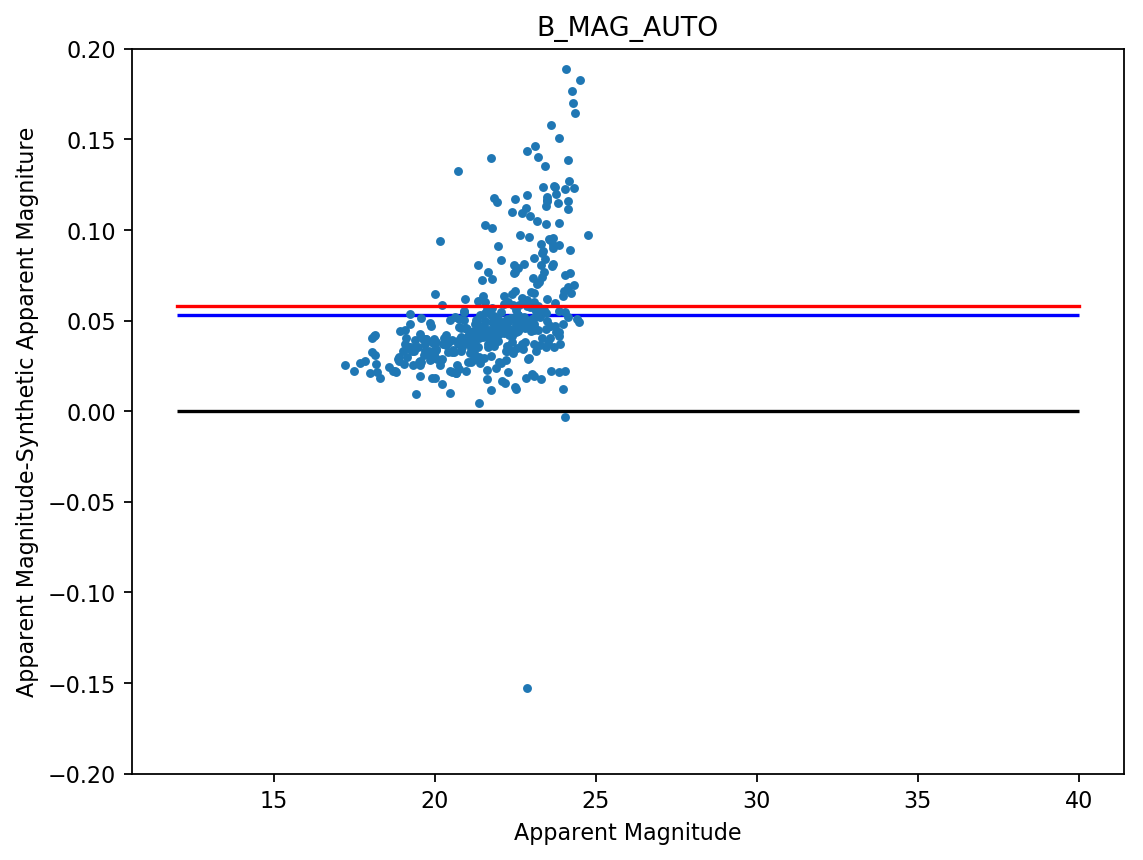

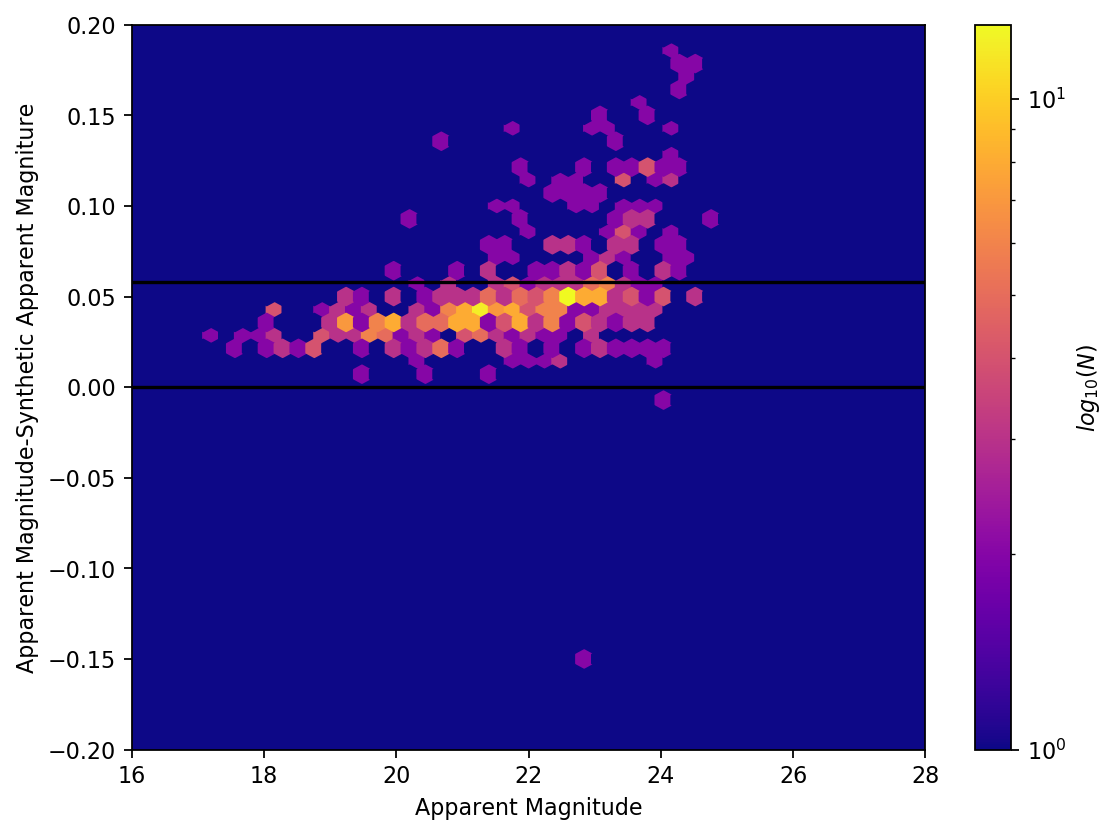

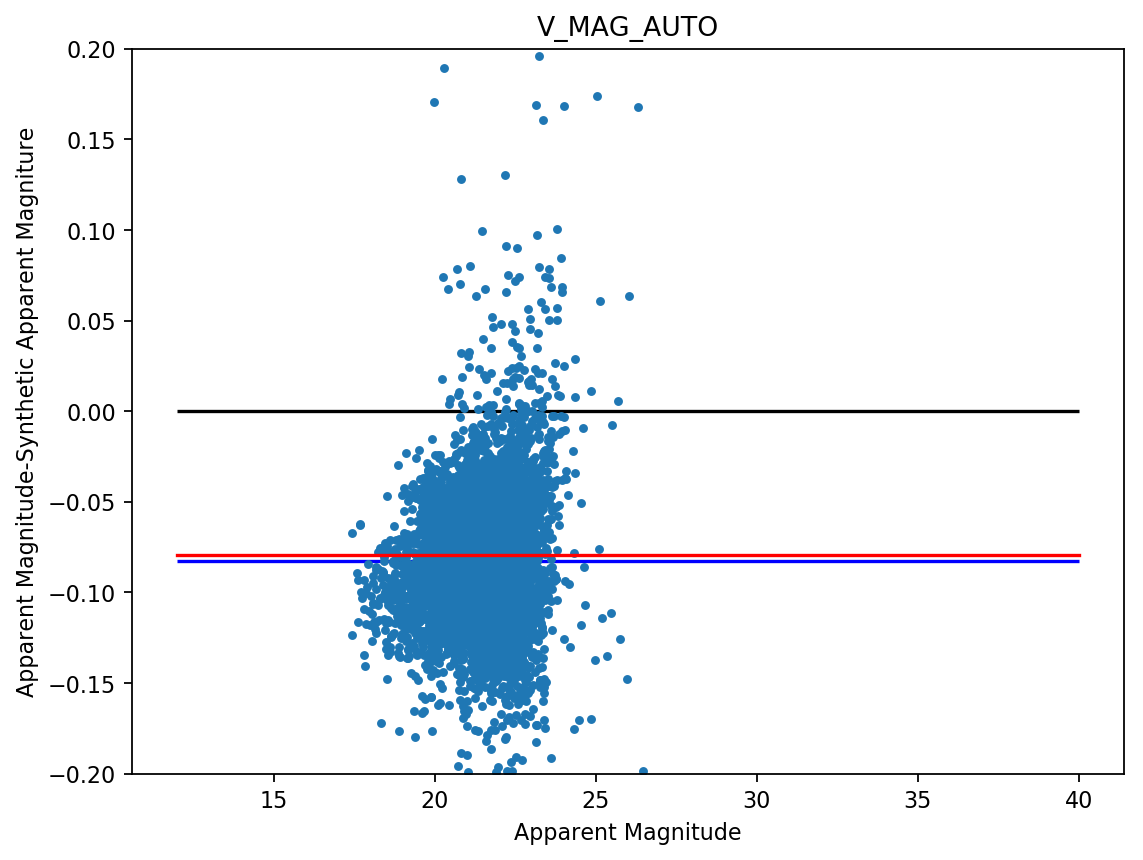

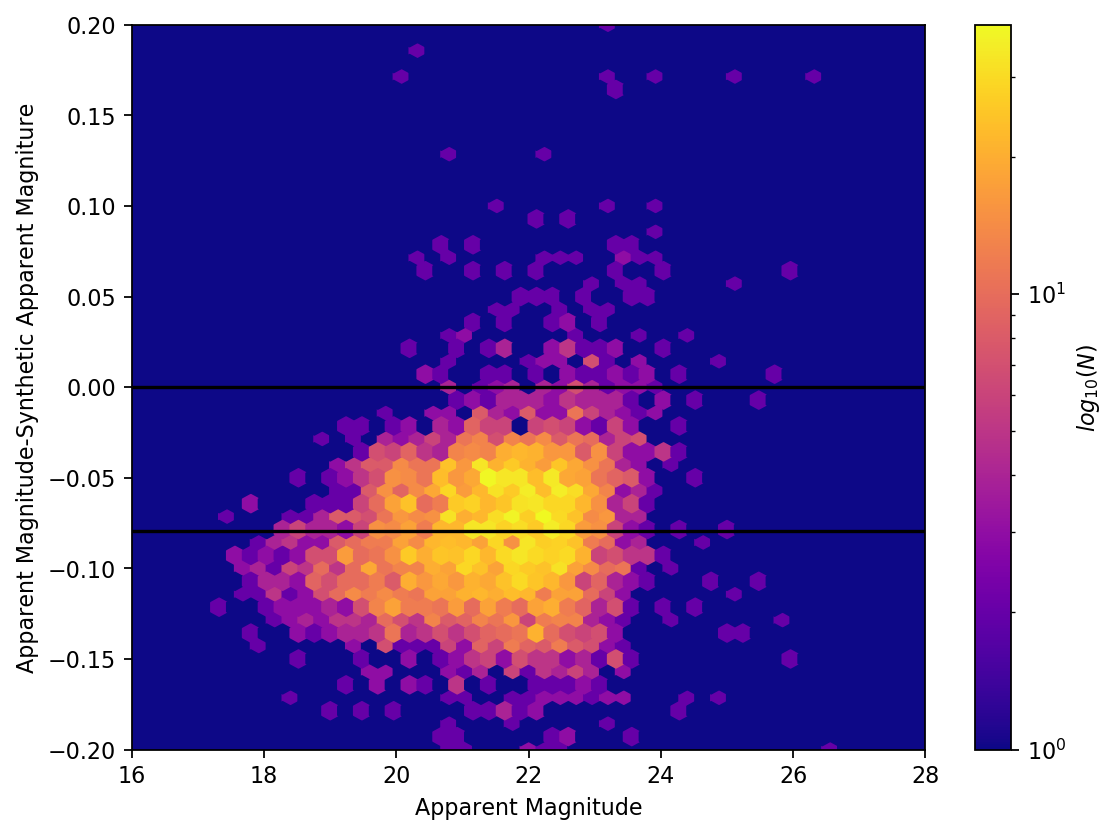

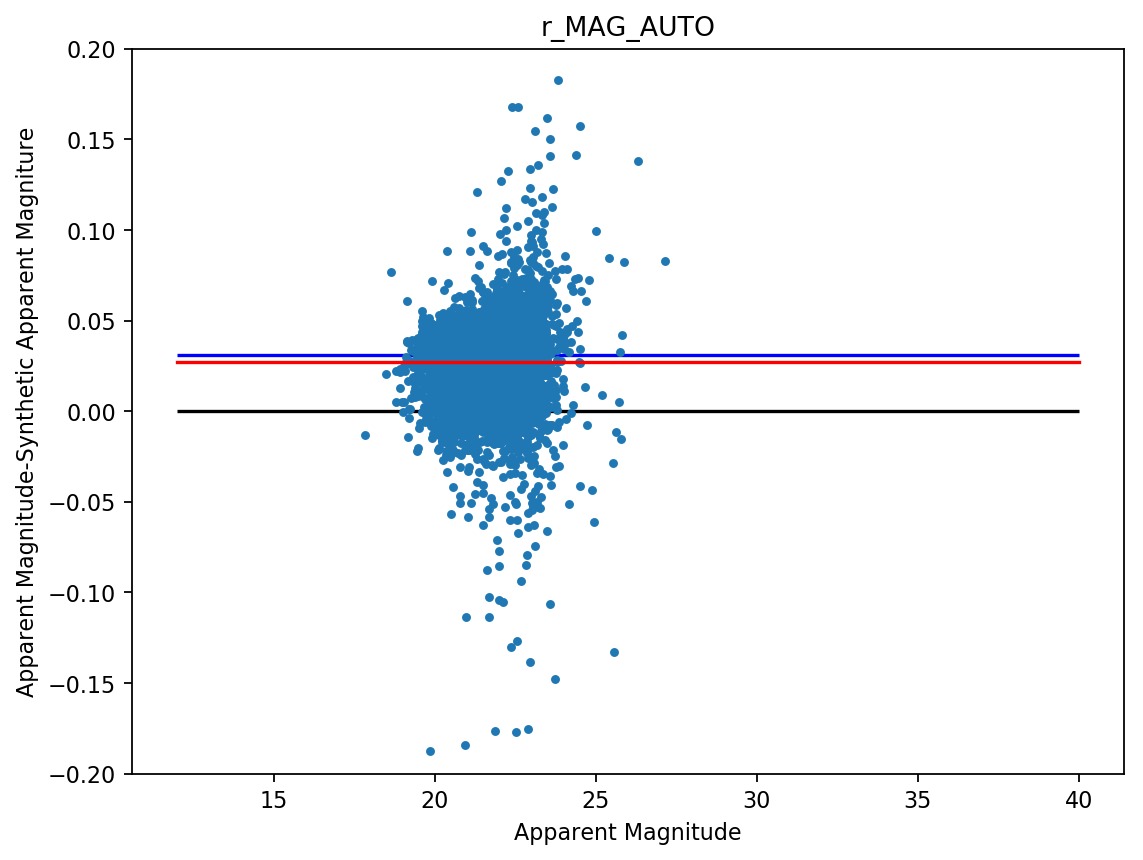

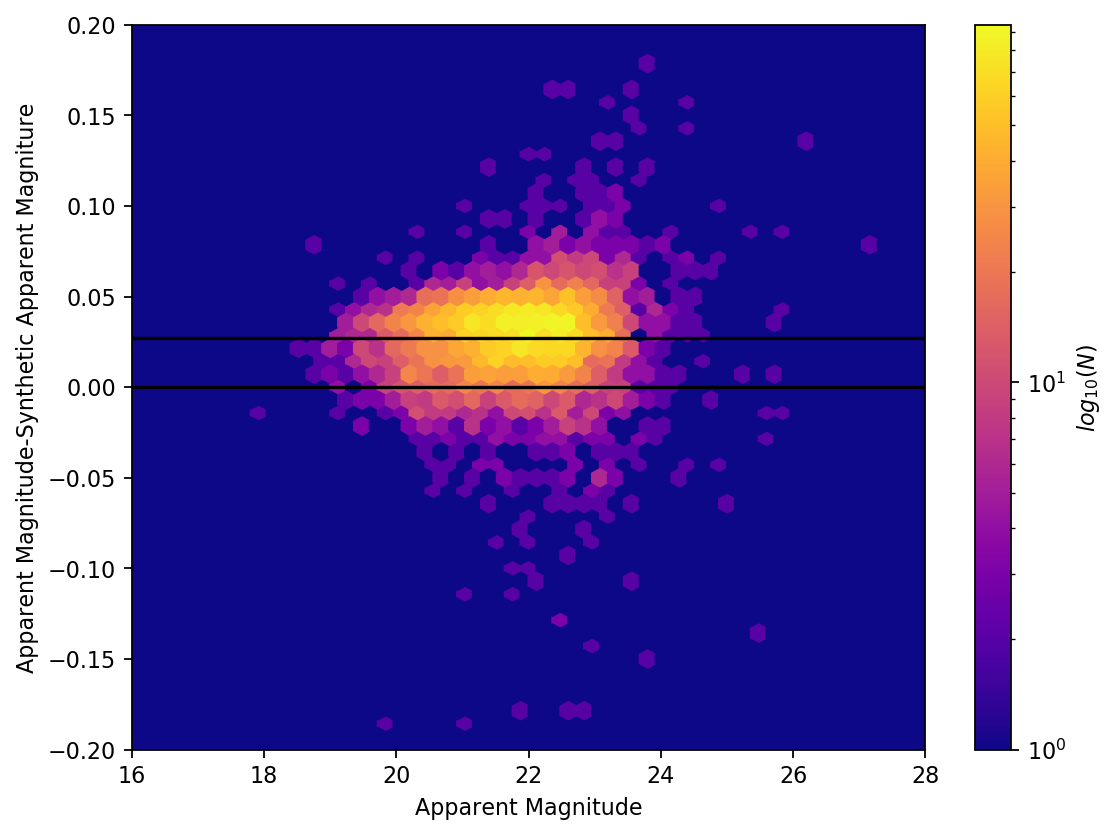

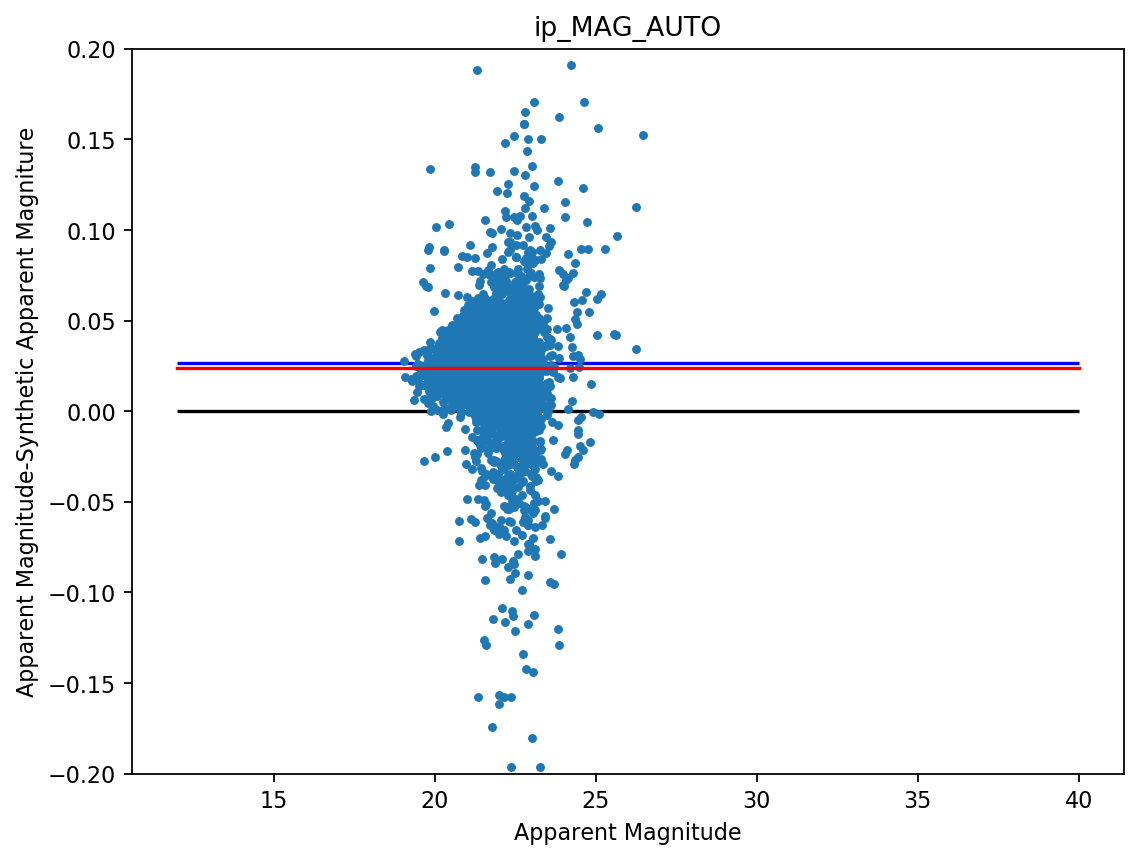

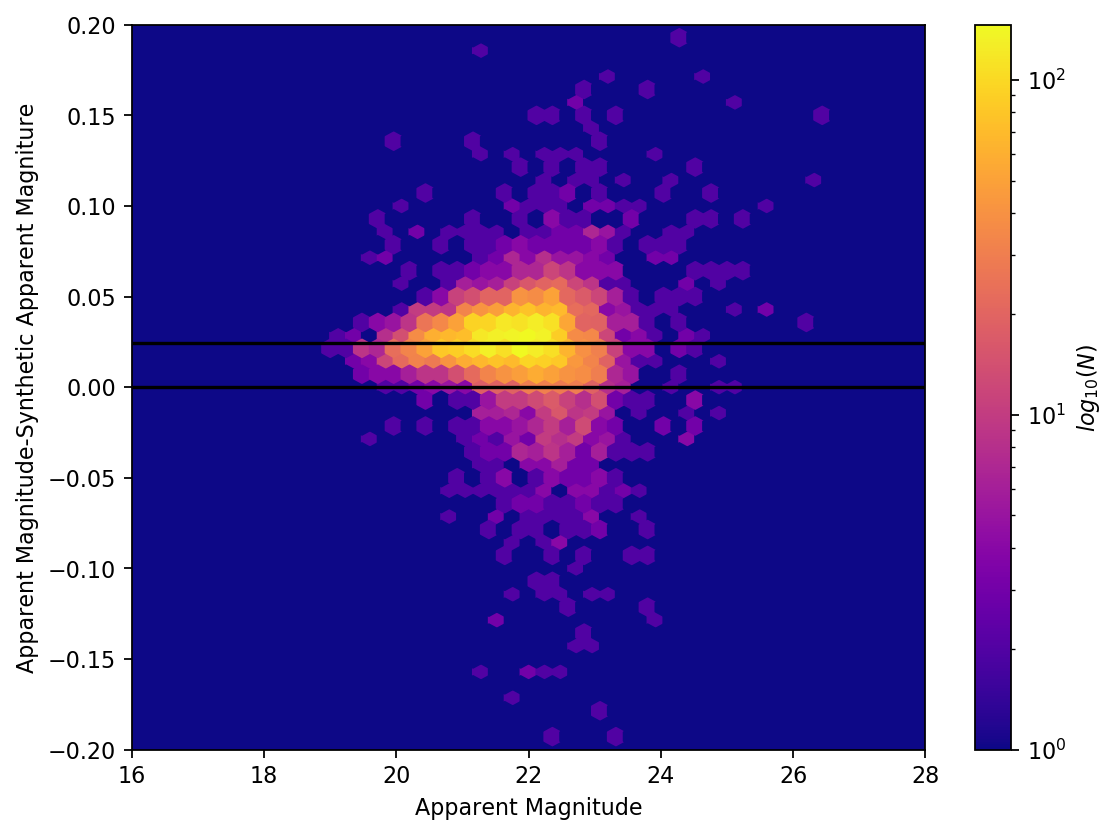

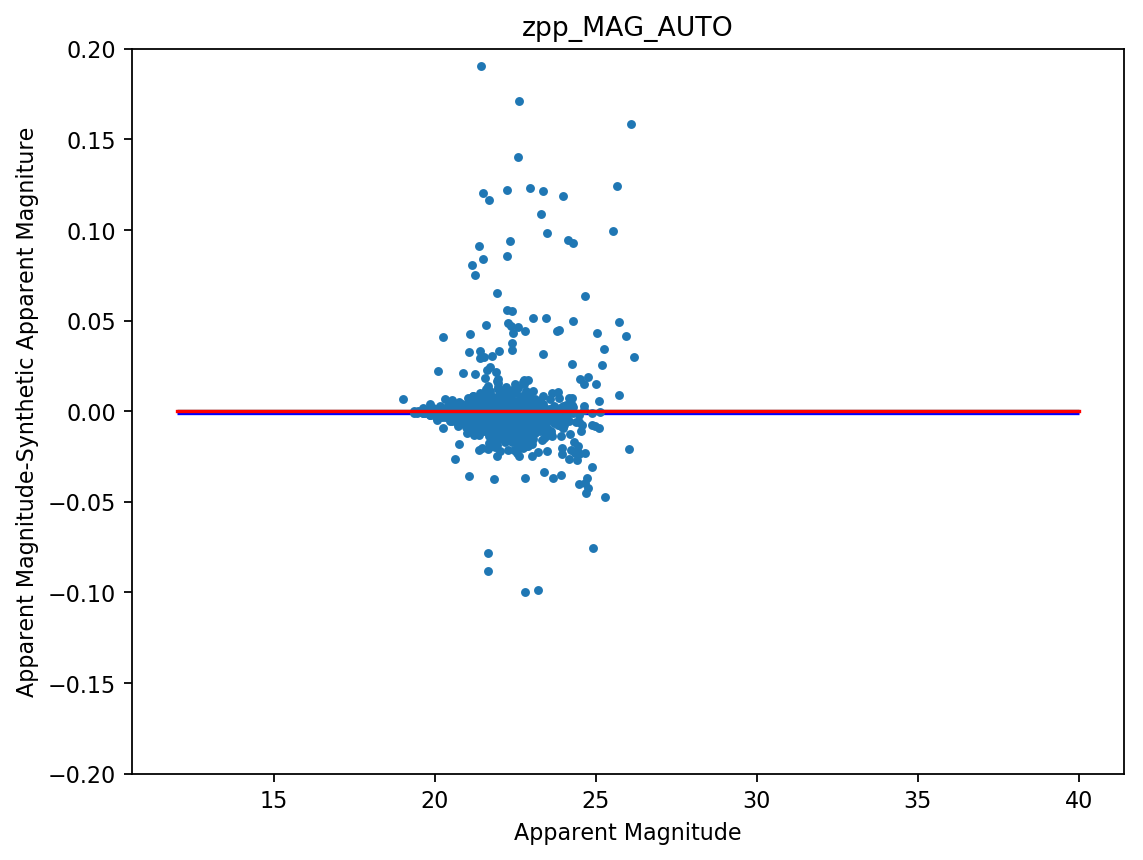

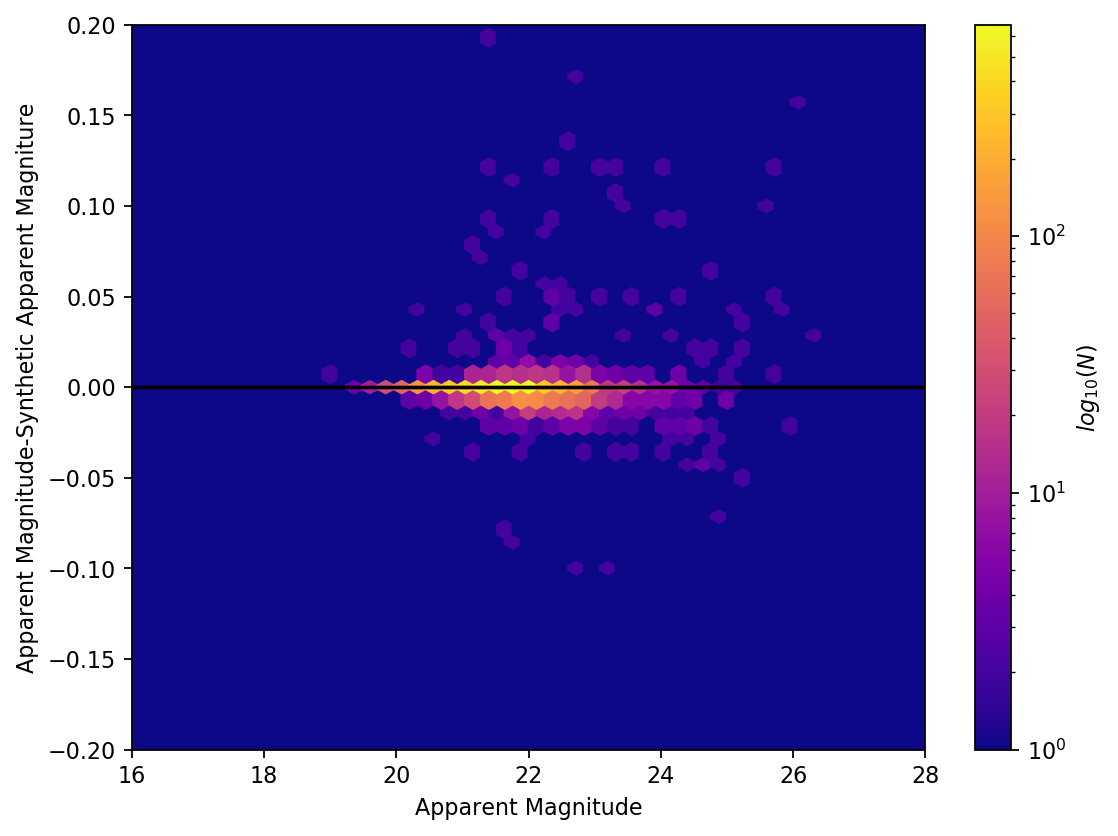

In [30]:
if not os.path.exists('offset_plots'):
    os.mkdir('offset_plots')
z_range_dict_low={'B_MAG_AUTO':0.0,
                  'V_MAG_AUTO':0.1,
                  'r_MAG_AUTO':0.35,
                  'ip_MAG_AUTO':0.55,
                  'zpp_MAG_AUTO':0.75}
z_range_dict_high={'B_MAG_AUTO':0.1,
                   'V_MAG_AUTO':0.35,
                   'r_MAG_AUTO':0.55,
                   'ip_MAG_AUTO':0.75,
                   'zpp_MAG_AUTO':1.0}
filter_offset_dict={'B_MAG_AUTO':0.1,
                   'V_MAG_AUTO':0.35,
                   'r_MAG_AUTO':0.55,
                   'ip_MAG_AUTO':0.75,
                   'zpp_MAG_AUTO':1.0}

for f in filter_mags:
    pdf = matplotlib.backends.backend_pdf.PdfPages('offset_plots/'+f+'synth_vs_meas.pdf')
    p_init=models.Polynomial1D(degree=0)
    fitter=fitting.LinearLSQFitter()
    p=fitter(p_init,
             Spec_Cat.loc[
                 (Spec_Cat.final_z>z_range_dict_low[f])&
                 (Spec_Cat.final_z<z_range_dict_high[f])&
                 (Spec_Cat.final_use<2)&
                 (Spec_Cat.TYPE==0)&
                 (Spec_Cat[filter_mags_to_synthetic[f]].notnull()),
                 f],
             Spec_Cat.loc[
                 (Spec_Cat.final_z>z_range_dict_low[f])&
                 (Spec_Cat.final_z<z_range_dict_high[f])&
                 (Spec_Cat.final_use<2)&
                 (Spec_Cat.TYPE==0)&
                 (Spec_Cat[filter_mags_to_synthetic[f]].notnull()),
                 f]-Spec_Cat.loc[
                 (Spec_Cat.final_z>z_range_dict_low[f])&
                 (Spec_Cat.final_z<z_range_dict_high[f])&
                 (Spec_Cat.final_use<2)&
                 (Spec_Cat.TYPE==0)&
                 (Spec_Cat[filter_mags_to_synthetic[f]].notnull()),
                 filter_mags_to_synthetic[f]])
    print('{} Fit intercept={}'.format(f,p.c0.value))
    filter_offset_dict[f]=p.c0.value
    fig1=plt.figure(figsize=(8,6),dpi=160)
    plt.plot(Spec_Cat.loc[
        (Spec_Cat.final_z>z_range_dict_low[f])&
        (Spec_Cat.final_z<z_range_dict_high[f])&
        (Spec_Cat.final_use<2)&
        (Spec_Cat.TYPE==0),
        f],
             Spec_Cat.loc[
                 (Spec_Cat.final_z>z_range_dict_low[f])&
                 (Spec_Cat.final_z<z_range_dict_high[f])&
                 (Spec_Cat.final_use<2)&
                 (Spec_Cat.TYPE==0),
                 f]-Spec_Cat.loc[
                 (Spec_Cat.final_z>z_range_dict_low[f])&
                 (Spec_Cat.final_z<z_range_dict_high[f])&
                 (Spec_Cat.final_use<2)&
                 (Spec_Cat.TYPE==0),
                 filter_mags_to_synthetic[f]],'.')
    plt.xlabel('Apparent Magnitude')
    plt.ylabel('Apparent Magnitude-Synthetic Apparent Magniture')
    plt.hlines(0,12,40)
    plt.plot(np.linspace(12,40,60),p(np.linspace(12,40,60)),color='red')
    plt.hlines(Spec_Cat.loc[(Spec_Cat.final_z>z_range_dict_low[f])&
                     (Spec_Cat.final_z<z_range_dict_high[f])&
                     (Spec_Cat.final_use<2)&
                     (Spec_Cat.TYPE==0),
                     f].median()-Spec_Cat.loc[
            (Spec_Cat.final_z>z_range_dict_low[f])&
            (Spec_Cat.final_z<z_range_dict_high[f])&
            (Spec_Cat.final_use<2)&
            (Spec_Cat.TYPE==0),
            filter_mags_to_synthetic[f]].median(),12,40,color='blue')
    plt.title(f)
    plt.ylim(-0.2,0.2)
    pdf.savefig(fig1)
    fig2,ax=plt.subplots(figsize=(8,6),dpi=160)
    _=ax.hexbin(Spec_Cat.loc[(Spec_Cat.final_z>z_range_dict_low[f])&
                             (Spec_Cat.final_z<z_range_dict_high[f])&
                             (Spec_Cat.final_use<2)&
                             (Spec_Cat.TYPE==0)&
                             (Spec_Cat[filter_mags_to_synthetic[f]].notnull()),
                             f],
                Spec_Cat.loc[(Spec_Cat.final_z>z_range_dict_low[f])&
                             (Spec_Cat.final_z<z_range_dict_high[f])&
                             (Spec_Cat.final_use<2)&
                             (Spec_Cat.TYPE==0)&
                             (Spec_Cat[filter_mags_to_synthetic[f]].notnull()),
                             f]-
                Spec_Cat.loc[(Spec_Cat.final_z>z_range_dict_low[f])&
                             (Spec_Cat.final_z<z_range_dict_high[f])&
                             (Spec_Cat.final_use<2)&
                             (Spec_Cat.TYPE==0)&
                             (Spec_Cat[filter_mags_to_synthetic['B_MAG_AUTO']].notnull()),
                             filter_mags_to_synthetic[f]],
        gridsize=50,
        cmap='plasma',
           extent=[16, 28, -0.2, 0.2],
           bins='log')
    ax.hlines(0,16,28)
    ax.hlines(Spec_Cat.loc[(Spec_Cat.final_z>z_range_dict_low[f])&
                     (Spec_Cat.final_z<z_range_dict_high[f])&
                     (Spec_Cat.final_use<2)&
                     (Spec_Cat.TYPE==0),
                     f].mean()-Spec_Cat.loc[
            (Spec_Cat.final_z>z_range_dict_low[f])&
            (Spec_Cat.final_z<z_range_dict_high[f])&
            (Spec_Cat.final_use<2)&
            (Spec_Cat.TYPE==0),
            filter_mags_to_synthetic[f]].mean(),
             16,28)
    cb=fig2.colorbar(_,ax=ax)
    cb.set_label('$log_{10}(N)$')
    ax.set_xlabel('Apparent Magnitude')
    ax.set_ylabel('Apparent Magnitude-Synthetic Apparent Magniture')
    pdf.savefig(fig2)
    print('Apparent Magnitude Median = {} | Synthetic Magnitude Median = {}'.format(
        Spec_Cat.loc[(Spec_Cat.final_z>z_range_dict_low[f])&
                          (Spec_Cat.final_z<z_range_dict_high[f])&
                          (Spec_Cat.final_use<2)&
                          (Spec_Cat.TYPE==0),
                     f].median(),
        Spec_Cat.loc[(Spec_Cat.final_z>z_range_dict_low[f])&
                          (Spec_Cat.final_z<z_range_dict_high[f])&
                          (Spec_Cat.final_use<2)&
                          (Spec_Cat.TYPE==0),
                     filter_mags_to_synthetic[f]].median(),
        )
         )
    print('median difference = {} | mean difference={}'.format(
        Spec_Cat.loc[(Spec_Cat.final_z>z_range_dict_low[f])&
                     (Spec_Cat.final_z<z_range_dict_high[f])&
                     (Spec_Cat.final_use<2)&
                     (Spec_Cat.TYPE==0),
                     f].median()-Spec_Cat.loc[
            (Spec_Cat.final_z>z_range_dict_low[f])&
            (Spec_Cat.final_z<z_range_dict_high[f])&
            (Spec_Cat.final_use<2)&
            (Spec_Cat.TYPE==0),
            filter_mags_to_synthetic[f]].median(),
        Spec_Cat.loc[(Spec_Cat.final_z>z_range_dict_low[f])&
                     (Spec_Cat.final_z<z_range_dict_high[f])&
                     (Spec_Cat.final_use<2)&
                     (Spec_Cat.TYPE==0),
                     f].mean()-Spec_Cat.loc[
            (Spec_Cat.final_z>z_range_dict_low[f])&
            (Spec_Cat.final_z<z_range_dict_high[f])&
            (Spec_Cat.final_use<2)&
            (Spec_Cat.TYPE==0),
            filter_mags_to_synthetic[f]].mean()
    )
         )
    print(' ')
    pdf.close()


In [9]:
Spec_Cat['BJ0_vega_absmag']=np.nan

Below limits the number of objects because it only calculates absolute magnitudes for objects with redshift less than 1

In [10]:
for f in filter_mags:
    Spec_Cat.loc[
        (Spec_Cat.final_z>z_range_dict_low[f])&
        (Spec_Cat.final_z<z_range_dict_high[f]),
        'BJ0_vega_absmag']=Spec_Cat.loc[
        (Spec_Cat.final_z>z_range_dict_low[f])&
        (Spec_Cat.final_z<z_range_dict_high[f]),
        f]-filter_offset_dict[f]-cosmo.distmod(Spec_Cat.loc[
        (Spec_Cat.final_z>z_range_dict_low[f])&
        (Spec_Cat.final_z<z_range_dict_high[f]),
        'final_z']).value-Spec_Cat.loc[(Spec_Cat.final_z>z_range_dict_low[f])&
        (Spec_Cat.final_z<z_range_dict_high[f]),
        f.split('_')[0]+'_kcorr_BJ0']+0.09
    print(f)
Spec_Cat.loc[Spec_Cat.final_z>1,
             'BJ0_vega_absmag']=Spec_Cat.loc[Spec_Cat.final_z>1,
                                             'zpp_MAG_AUTO']-filter_offset_dict['zpp_MAG_AUTO']-cosmo.distmod(
Spec_Cat.loc[Spec_Cat.final_z>1,
              'final_z']).value-Spec_Cat.loc[Spec_Cat.final_z>1,
                                             'zpp_kcorr_BJ0']+0.09

B_MAG_AUTO
V_MAG_AUTO
r_MAG_AUTO
ip_MAG_AUTO
zpp_MAG_AUTO


In [11]:
Spec_Cat['BJ0_synthetic_vega_absmag']=Spec_Cat['BJ0_synthetic_vega_mag']-cosmo.distmod(Spec_Cat.final_z)

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/astropy/cosmology/core.py:1922: RuntimeWarning: invalid value encountered in sqrt
  return 2 * np.sqrt(x) * hyp2f1(1./6, 1./2, 7./6, -x**3)
/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/astropy/cosmology/core.py:1447: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


In [12]:
Spec_Cat['BJ0-VJ0']=Spec_Cat.BJ0_synthetic_vega_mag-Spec_Cat.VJ0_synthetic_vega_mag

Below we need to calculate surface brightness. Do this using the absolute magnitude. 

SB=$M_{B}+2.5\times~log_{10}(2\pi~R_{e}^{2})+36.572$

effective radius as a function of wavelength


$log_{10}(R_{e})=-0.108\times~log_{10}(\lambda)+0.887$


When comparing the radius at two wavelengths 


$log_{10}(R_{e,\lambda_{1}})-log_{10}(R_{e,\lambda_{2}})=-0.108\times~log_{10}(\lambda_{1})+0.108\times~log_{10}(\lambda_{2})+0.887-0.887$

which can be reduced to

$log_{10}(\frac{R_{e,\lambda_{1}}}{R_{e,\lambda_{2}}})=-0.108\times~log_{10}(\frac{\lambda_{1}}{\lambda_{2}})$

$\frac{R_{e,B}}{R_{e,J}}=\frac{\lambda_{B}}{\lambda_{J}}^{-0.108}$

$\frac{R_{e,B}}{R_{e,J}}=\frac{\lambda_{J}}{\lambda_{B}}^{0.108}$

Need to account for fact that radius is observed J. To get to emitted wavelength need to divide $\lambda_{J}$ by (1+z)

$\frac{R_{e,B}}{R_{e,J}}=\frac{\lambda_{J}}{\lambda_{B}}^{0.108}\times(1+z)^{-0.108}$

$\lambda_{J}=1.25e^{-6}~~ \lambda_{B}=0.445e^{-6}$

$R_{e,B} = 1.12 \times (1+z)^{-0.108} \times R_{e,J}$

In [13]:
Spec_Cat['BJ0_vega_surface_brightness']=\
(Spec_Cat['BJ0_vega_absmag']+
 2.5*np.log10(
     2*np.pi*
     np.power(1/cosmo.arcsec_per_kpc_proper(Spec_Cat.final_z.values).value*
              (
                  (
                      1.12*
                      (1+Spec_Cat.final_z)**(-0.108)
                  )*
                  (
                      Spec_Cat.FLUX_RADIUS.values*
                      0.15
                  )
              )
              ,2)
 )
 +2.5*np.log10((360*60*60/(2*np.pi*0.01))**2))

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


In [14]:
Spec_Cat['BJ0_synthetic_vega_surface_brightness']=\
(Spec_Cat['BJ0_synthetic_vega_absmag']+
 2.5*np.log10(
     2*np.pi*
     np.power(1/cosmo.arcsec_per_kpc_proper(Spec_Cat.final_z.values).value*
              (
                  (
                      1.12*
                      (1+Spec_Cat.final_z)**(-0.108)
                  )*
                  (
                      Spec_Cat.FLUX_RADIUS.values*
                      0.15
                  )
              )
              ,2)
 )
 +2.5*np.log10((360*60*60/(2*np.pi*0.01))**2))

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


In [15]:
Spec_Cat['is_LCBG']=0

In [16]:
Spec_Cat.loc[(Spec_Cat.BJ0_vega_absmag.values<-18.5)&(Spec_Cat.BJ0_vega_surface_brightness.values<21)&(Spec_Cat['BJ0-VJ0'].values<0.6),'is_LCBG']=1

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [26]:
Spec_Cat.to_csv(catbasedir+'/Laigle_LCBG_Catalog.csv')

# Below code just does a bunch of plotting to look at effective radius

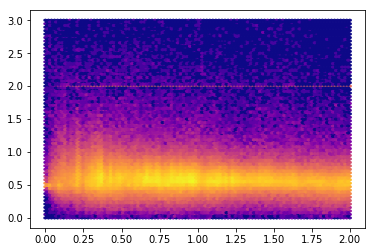

In [19]:
Spec_Cat.loc[(Spec_Cat.final_use==1)&(Spec_Cat.is_LCBG==1)]
plt.hexbin(Spec_Cat['final_z'],
           Spec_Cat['FLUX_RADIUS']*0.15,
           gridsize=100,
           cmap='plasma',
           extent=[0, 2, 0, 3],bins='log')

In [38]:
list(Spec_Cat.columns)

['NUMBER',
 'ID2006',
 'ID2008',
 'RA',
 'DEC',
 'FLUX_RADIUS',
 'u_MAG_AUTO',
 'u_MAGERR_AUTO',
 'B_MAG_AUTO',
 'B_MAGERR_AUTO',
 'V_MAG_AUTO',
 'V_MAGERR_AUTO',
 'r_MAG_AUTO',
 'r_MAGERR_AUTO',
 'ip_MAG_AUTO',
 'ip_MAGERR_AUTO',
 'zpp_MAG_AUTO',
 'zpp_MAGERR_AUTO',
 'Y_MAG_AUTO',
 'Y_MAGERR_AUTO',
 'J_MAG_AUTO',
 'J_MAGERR_AUTO',
 'H_MAG_AUTO',
 'H_MAGERR_AUTO',
 'Ks_MAG_AUTO',
 'Ks_MAGERR_AUTO',
 'ZPDF',
 'TYPE',
 'deimos_id',
 'deimos_ra',
 'deimos_dec',
 'deimos_zspec',
 'deimos_qf',
 'deimos_q',
 'catalog',
 'ID_06',
 'Z_USE',
 'Z_BEST',
 'final_z',
 'final_use',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c6',
 'u_maggies',
 'u_invervar',
 'B_maggies',
 'B_invervar',
 'V_maggies',
 'V_invervar',
 'r_maggies',
 'r_invervar',
 'ip_maggies',
 'ip_invervar',
 'zpp_maggies',
 'zpp_invervar',
 'Y_maggies',
 'Y_invervar',
 'J_maggies',
 'J_invervar',
 'H_maggies',
 'H_invervar',
 'Ks_maggies',
 'Ks_invervar',
 'B_synthetic_maggies',
 'B0_synthetic_maggies',
 'V_synthetic_maggies',
 'V0_synthe

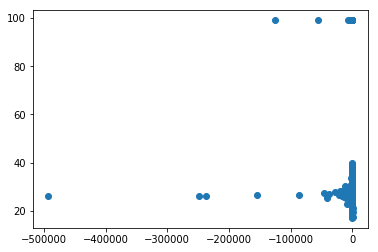

In [37]:
plt.scatter(Spec_Cat.FLUX_RADIUS,Spec_Cat.B_MAG_AUTO)

In [20]:
x=pd.read_csv('/Users/lucashunt/ASTRODATA/LCBG_LUMINOSITY_FUNCTION/COSMOS_CATALOGS/Photometry/COSMOS_CONVERTED_CATALOG.csv')

In [21]:
combine_laigle_andrews=pd.merge(left=Spec_Cat,
                                right=x.loc[x.is_LCBG==1,['COSMOS_ID_06','Rh']],
                                how='left',
                                left_on=['ID2006'],
                                right_on=['COSMOS_ID_06'])

235        5.195
236        7.418
237        7.625
238       11.493
239        2.499
240        5.919
241       13.578
242       11.731
243       14.718
244        6.965
245        5.939
246       20.621
247        6.589
248        6.070
249        7.259
250        8.559
251        8.034
252        6.336
253        7.572
254       10.019
255       12.891
256       12.793
257       20.550
258        5.765
259        6.849
260        9.555
261       11.071
262        4.920
263        6.490
264        5.415
           ...  
644280    10.728
644281    12.083
644282    17.189
644283    22.293
644284    13.873
644285    24.548
644286    17.174
644287    14.196
644288    36.454
644289    12.190
644290    50.103
644291    54.365
644292     1.014
644293    16.120
644294    16.412
644295    12.465
644296    12.340
644297    15.385
644298    19.842
644299     9.246
644300     1.066
644301    11.492
644302    22.378
644303    13.153
644304    14.272
644305     7.232
644306    12.720
644307     1.0

(array([  2.61330000e+04,   8.21770000e+04,   3.83410000e+04,
          1.11790000e+04,   6.21700000e+03,   1.56000000e+02,
          6.00000000e+01,   1.13000000e+03,   1.00000000e+01,
          6.00000000e+00,   2.22300000e+03,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 array([ 0.  ,  0.15,  0.3 ,  0.45,  0.6 ,  0.75,  0.9 ,  1.05,  1.2 ,
         1.35,  1.5 ,  1.65,  1.8 ,  1.95,  2.1 ,  2.25,  2.4 ,  2.55,
         2.7 ,  2.85,  3.  ]),
 <a list of 20 Patch objects>)

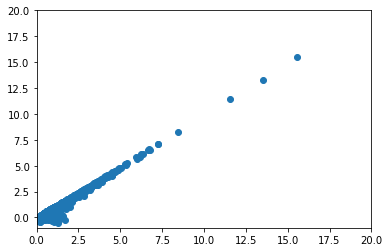

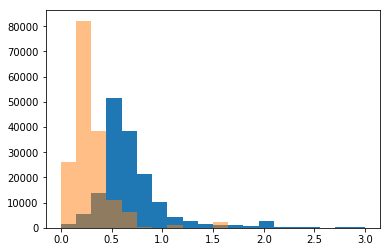

In [33]:
combine_laigle_andrews['FLUX_RADIUS_arcsec']=combine_laigle_andrews['FLUX_RADIUS']*0.15
print(combine_laigle_andrews.loc[combine_laigle_andrews.Rh.notnull(),'Rh'])
combine_laigle_andrews['Rh_arcsec']=combine_laigle_andrews['Rh']*0.03
combine_laigle_andrews.loc[combine_laigle_andrews.Rh.notnull(),['FLUX_RADIUS_arcsec','Rh_arcsec']]
plt.figure()
plt.scatter(combine_laigle_andrews.loc[(combine_laigle_andrews.Rh.notnull())&
                                       (combine_laigle_andrews.TYPE==0)&
                                       (combine_laigle_andrews.ID2006>0),
                                       'FLUX_RADIUS_arcsec'],
            combine_laigle_andrews.loc[(combine_laigle_andrews.Rh.notnull())&
                                       (combine_laigle_andrews.TYPE==0)&
                                       (combine_laigle_andrews.ID2006>0),
                                       'FLUX_RADIUS_arcsec']-combine_laigle_andrews.loc[(combine_laigle_andrews.Rh.notnull())&
                                       (combine_laigle_andrews.TYPE==0)&
                                       (combine_laigle_andrews.ID2006>0),
                                       'Rh_arcsec']
           )
plt.xlim(0,20)
plt.ylim(-1,20)

plt.figure()
plt.hist(combine_laigle_andrews.loc[combine_laigle_andrews.Rh_arcsec.notnull(),'FLUX_RADIUS_arcsec'],20,range=(0,3))
plt.hist(combine_laigle_andrews.loc[combine_laigle_andrews.Rh_arcsec.notnull(),'Rh_arcsec'],20,range=(0,3),alpha=0.5)